## Test for negative selection

In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

NUCLEOTIDE_TRANSFORMER_MODEL = '500M_human_ref' #@param['500M_human_ref', '500M_1000G', '2B5_1000G', '2B5_multi_species']
SEQUENCE_LENGTH = 501

from numpy import linalg as LA
import pandas as pd 
import numpy as np 

import pysam 

import sys 
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

from read_model import read_model
from bases import BASES 
from pack_unpack import pack

MCHALE_MODEL = read_model(f"{CONSTRAINT_TOOLS}/dist/model-germline-grch38-Nonly.kmerSize-3.trainSet-noncoding.json")

In [2]:
def compute_heat_map(window, embeddings): 
  chromosome = window['chromosome']
  start = int(window['start'])
  end = int(window['end'])

  with pysam.FastaFile(MCHALE_MODEL['genome']) as genome: # type: ignore
    # "fetch" API: https://pysam.readthedocs.io/en/latest/api.html?highlight=fasta#pysam.FastaFile
    # Note that fetch(region=region) does not work if the coordinates in "region" contains commas
    # Workaround is to parse "region" into "chromosome", "start", "end": 
    sequence = genome.fetch(chromosome, start, end)    
    sequence = sequence.upper()

  distances_for_all_sites = []
  mask = np.ones((len(BASES), len(sequence)))
  for site_index, REF in enumerate(sequence): 
    REF_index = BASES.index(REF)
    mask[REF_index, site_index] = 0
    REF_embedding = embeddings[REF_index, site_index]
    distances_for_site = []
    for allele_index in range(len(BASES)): 
      embedding = embeddings[allele_index, site_index]
      delta = REF_embedding - embedding

      # section A.5.2 of https://www.biorxiv.org/content/10.1101/2023.01.11.523679v2
      # details metrics that could be used to quantify distance between embeddings: 
      #    (i) the L1 distance (Manhattan), 
      #    (ii) the L2 distance (Euclidean), 
      #    (iii) the cosine similarity 
      #    (iv) the dot-product (not normalized cosine similarity) 
      distance = LA.norm(delta, 2) 

      distances_for_site.append(distance)
    distances_for_all_sites.append(distances_for_site)
  distances_for_all_sites = np.array(distances_for_all_sites)
  heat_map = distances_for_all_sites.T 

  return heat_map, mask # both indexed as BASES X [site1, site2, ...]

def fetch_window(window_index, directory): 
  window = pd.read_csv(f'{directory}/window-{window_index}.bed', sep='\t')
  assert len(window) == 1
  window = window.iloc[0]
  return window

def fetch_embeddings(window_index, directory): 
  sub_directory = f'{directory}/{NUCLEOTIDE_TRANSFORMER_MODEL}.{SEQUENCE_LENGTH}' 
  embeddings_filename = f'{sub_directory}/window-{window_index}.embeddings.{NUCLEOTIDE_TRANSFORMER_MODEL}.{SEQUENCE_LENGTH}.npy'
  embeddings = np.load(embeddings_filename, allow_pickle=True)
  return embeddings

def compute_heat_map_wrapper(window_index, directory): 
  window = fetch_window(window_index, directory)
  embeddings = fetch_embeddings(window_index, directory)
  return compute_heat_map(window, embeddings)

compute_heat_map_wrapper(
  window_index=0, 
  directory=f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/enhancer-characteristics-enrichment-subset-inference'
)

(array([[0.       , 0.       , 0.       , ..., 1.9941801, 0.       ,
         1.9081959],
        [2.595312 , 3.805649 , 2.8977833, ..., 1.6820358, 2.273474 ,
         2.2385428],
        [2.640824 , 2.933897 , 3.8397076, ..., 1.8109329, 1.4833192,
         0.       ],
        [3.4823732, 3.5007   , 2.3707097, ..., 0.       , 2.2311282,
         1.897106 ]], dtype=float32),
 array([[0., 0., 0., ..., 1., 0., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 0.],
        [1., 1., 1., ..., 0., 1., 1.]]))

In [3]:
from snvs import fetch_SNVs
from colorize import print_json
from kmer import CpG 

def get_snvs(window): 
  with pysam.TabixFile(MCHALE_MODEL['mutations']) as mutations, pysam.FastaFile(MCHALE_MODEL['genome']) as genome: # type: ignore
    SNVs = fetch_SNVs(
      mutations, 
      genome, 
      region=pack(window['chromosome'], window['start'], window['end']),
      meta=MCHALE_MODEL, 
      number_chromosomes_min=MCHALE_MODEL['numberChromosomesMin']
    )
  return [
    {
      **SNV,
      'position_offset': SNV['position'] - int(window['start']),
      'CpG+': CpG(SNV['kmer'])
    }
    for SNV in SNVs
  ]

def get_snvs_wrapper(window_index, directory): 
  window = fetch_window(window_index, directory)
  return get_snvs(window)

print_json(get_snvs_wrapper(
  window_index=0, 
  directory=f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/enhancer-characteristics-enrichment-subset-inference'
))

[
  {
    "chromosome": "chr1",
    "position": 5814033,
    "REF": "A",
    "ALT": "C",
    "number_ALT_chromosomes": 2,
    "number_chromosomes": 152142,
    "kmer": "TAA",
    "position_offset": 33,
    "CpG+": false
  },
  {
    "chromosome": "chr1",
    "position": 5814037,
    "REF": "G",
    "ALT": "C",
    "number_ALT_chromosomes": 1,
    "number_chromosomes": 152066,
    "kmer": "AGG",
    "position_offset": 37,
    "CpG+": false
  },
  {
    "chromosome": "chr1",
    "position": 5814038,
    "REF": "G",
    "ALT": "T",
    "number_ALT_chromosomes": 1,
    "number_chromosomes": 152106,
    "kmer": "GGG",
    "position_offset": 38,
    "CpG+": false
  },
  {
    "chromosome": "chr1",
    "position": 5814040,
    "REF": "T",
    "ALT": "C",
    "number_ALT_chromosomes": 1,
    "number_chromosomes": 151878,
    "kmer": "GTG",
    "position_offset": 40,
    "CpG+": false
  },
  {
    "chromosome": "chr1",
    "position": 5814053,
    "REF": "A",
    "ALT": "G",
    "number_ALT_chr

In [4]:
from ravel_unravel import ravel

def compute_ALT_effects_and_existence(window_index, directory): 
  window = fetch_window(window_index, directory)
  number_sites = int(window['end']) - int(window['start'])

  SNVs = get_snvs(window)

  SNV_present = np.zeros(shape=(len(BASES), number_sites))
  for SNV in SNVs: 
    site_index = SNV['position_offset']
    if site_index >= number_sites: continue
    ALT_index = BASES.index(SNV['ALT'])
    SNV_present[ALT_index, site_index] = 1 

  embeddings = fetch_embeddings(window_index, directory)
  heat_map, mask = compute_heat_map(window, embeddings)

  SNV_present = ravel(SNV_present)
  heat_map = ravel(heat_map)
  mask = ravel(mask)

  mask = np.array(mask, dtype=bool)
  ALT_effect_size = heat_map[mask]
  ALT_exists_in_cohort = SNV_present[mask]
  ALT_exists_in_cohort = np.array(ALT_exists_in_cohort, dtype=bool)

  return ALT_effect_size, ALT_exists_in_cohort

def aggregate_ALT_effects_and_existence(directory): 
  import glob
  window_files = glob.glob(f"{directory}/*.bed")
  number_windows = len(window_files)

  ALT_effect_size_all_windows = [] 
  ALT_exists_in_cohort_all_windows = [] 
  for window_index in range(number_windows):
    ALT_effect_size, ALT_exists_in_cohort = compute_ALT_effects_and_existence(window_index, directory)
    ALT_effect_size_all_windows.extend(ALT_effect_size)
    ALT_exists_in_cohort_all_windows.extend(ALT_exists_in_cohort)

  ALT_effect_size_all_windows = np.array(ALT_effect_size_all_windows)
  ALT_exists_in_cohort_all_windows = np.array(ALT_exists_in_cohort_all_windows, dtype=bool)    

  return ALT_effect_size_all_windows, ALT_exists_in_cohort_all_windows

aggregate_ALT_effects_and_existence(
  directory=f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/enhancer-characteristics-enrichment-subset-inference'
)

(array([4.4419923, 3.2828379, 2.765223 , ..., 2.0379   , 2.7035623,
        2.7439568], dtype=float32),
 array([False, False, False, ...,  True,  True, False]))

negative selection
effect_size_threshold: 2.0
[[366499  28541]
 [ 22497   2463]] 1.4058643297891291 5.288822005426376e-50
effect_size_threshold: 3.0
[[241608  17518]
 [147388  13486]] 1.2619664757089772 3.2102462255838846e-84
effect_size_threshold: 4.0
[[124954   8451]
 [264042  22553]] 1.2629128080602265 3.736038139544271e-72
effect_size_threshold: 5.0
[[ 61693   4113]
 [327303  26891]] 1.232350219520841 3.1324849013656566e-35
effect_size_threshold: 6.0
[[ 32542   2119]
 [356454  28885]] 1.2444635000568616 2.2360483702645724e-22
effect_size_threshold: 7.0
[[ 18586   1248]
 [370410  29756]] 1.1963636102475497 4.314339409580768e-10
effect_size_threshold: 8.0
[[ 11330    763]
 [377666  30241]] 1.1890322430772788 1.5875908686603534e-06
effect_size_threshold: 9.0
[[  7310    494]
 [381686  30510]] 1.1828410961881655 0.00013629712966339302
effect_size_threshold: 10.0
[[  4918    322]
 [384078  30682]] 1.2201041008783187 0.00022884087217107284
effect_size_threshold: 11.0
[[  3485    228]
 [3

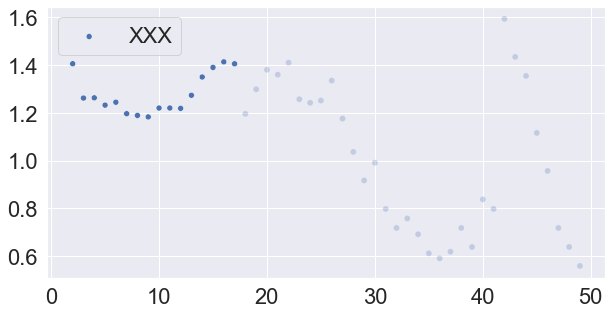

In [5]:
from scipy.stats import fisher_exact
from matplotlib import pyplot as plt
import seaborn as sns

plt.rcParams.update({
  'figure.figsize': (10, 5),
})

sns.set(font_scale=2)

def plot_enrichment_in_strong_alleles(
    directory, 
    label, 
    pvalue_threshold,
    test='negative selection'
):
  print(test)

  ALT_effect_size, ALT_exists_in_cohort = aggregate_ALT_effects_and_existence(directory)

  effect_size_thresholds = [] 
  odds_ratios = []
  pvalues = []
  for effect_size_threshold in np.arange(2, np.max(ALT_effect_size), 1):
    print(f'effect_size_threshold: {effect_size_threshold}')
  
    ALT_is_strong = ALT_effect_size > effect_size_threshold

    if test == 'negative selection': 
      table = np.array(pd.crosstab(np.logical_not(ALT_is_strong), ALT_exists_in_cohort))
    elif test == 'positive selection': 
      table = np.array(pd.crosstab(np.logical_not(ALT_is_strong), np.logical_not(ALT_exists_in_cohort)))
    else: 
      raise ValueError    
    
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html
    result = fisher_exact(table, alternative='greater')
    odds_ratio, pvalue = result.statistic, result.pvalue # type: ignore

    print(table, odds_ratio, pvalue)

    effect_size_thresholds.append(effect_size_threshold)
    odds_ratios.append(odds_ratio)
    pvalues.append(pvalue)

  sns.scatterplot(
    x=effect_size_thresholds, 
    y=odds_ratios, 
    alpha=[0.25 if pvalue > pvalue_threshold else 1.0 for pvalue in pvalues],
    label=label
  )

plot_enrichment_in_strong_alleles(
  directory=f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/enhancer-characteristics-enrichment-subset-inference',
  label='XXX',
  pvalue_threshold = 0.05
)

negative selection
effect_size_threshold: 2.0
[[366499  28541]
 [ 22497   2463]] 1.4058643297891291 5.288822005426376e-50
effect_size_threshold: 3.0
[[241608  17518]
 [147388  13486]] 1.2619664757089772 3.2102462255838846e-84
effect_size_threshold: 4.0
[[124954   8451]
 [264042  22553]] 1.2629128080602265 3.736038139544271e-72
effect_size_threshold: 5.0
[[ 61693   4113]
 [327303  26891]] 1.232350219520841 3.1324849013656566e-35
effect_size_threshold: 6.0
[[ 32542   2119]
 [356454  28885]] 1.2444635000568616 2.2360483702645724e-22
effect_size_threshold: 7.0
[[ 18586   1248]
 [370410  29756]] 1.1963636102475497 4.314339409580768e-10
effect_size_threshold: 8.0
[[ 11330    763]
 [377666  30241]] 1.1890322430772788 1.5875908686603534e-06
effect_size_threshold: 9.0
[[  7310    494]
 [381686  30510]] 1.1828410961881655 0.00013629712966339302
effect_size_threshold: 10.0
[[  4918    322]
 [384078  30682]] 1.2201041008783187 0.00022884087217107284
effect_size_threshold: 11.0
[[  3485    228]
 [3

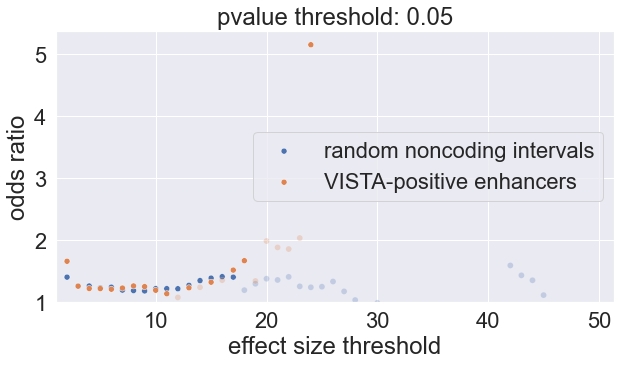

In [6]:
def plot_enrichment_in_strong_alleles_wrapper():
  pvalue_threshold = 0.05
  plot_enrichment_in_strong_alleles(
    directory=f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/enhancer-characteristics-enrichment-subset-inference',
    label='random noncoding intervals', 
    pvalue_threshold=pvalue_threshold
  )
  plot_enrichment_in_strong_alleles(
    directory=f'{CONSTRAINT_TOOLS_DATA}/vista-enhancers/vista-enhancers.positive.hg38.hg19-inference',
    label='VISTA-positive enhancers',
    pvalue_threshold=pvalue_threshold
  )
  plt.xlim([1, None])
  plt.ylim([1, None])
  plt.xlabel('effect size threshold')
  plt.ylabel('odds ratio')
  plt.title(f'pvalue threshold: {pvalue_threshold}')
  plt.show()

plot_enrichment_in_strong_alleles_wrapper()